# **Банк: отток клиентов**

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Заказчик предоставил исторические данные о поведении клиентов и расторжении договоров с банком.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# **Предоставленные заказчиком данные**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:  
- *RowNumber —* индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname —* фамилия
- *CreditScore —* кредитный рейтинг
- *Geography —* страна проживания
- *Gender —* пол
- *Age —* возраст
- *Tenure —* сколько лет человек является клиентом банка
- *Balance —* баланс на счёте
- *NumOfProducts —* количество продуктов банка, используемых клиентом
- *HasCrCard —* наличие кредитной карты
- *IsActiveMember —* активность клиента
- *EstimatedSalary —* предполагаемая зарплата  
- *Exited —* факт ухода клиента

# Цель проекта

Целью данного проекта стало построение модели машинного обучения для банка "Бета-Банк" для прогноза расторжения договора с банком, на основе данных об их пользовательском поведении. Модель поможет заказчику определить, уйдёт клиент из банка в ближайшее время или нет

## Исследование и предобработка предоставленных данных

Сперва я импортирую все необходимые для дальнейшей работы библиотеки:

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_curve, precision_score, 
                             recall_score, accuracy_score, 
                             f1_score, roc_auc_score, 
                             precision_recall_curve)

from sklearn.utils import shuffle
from scipy.stats import chi2_contingency

Объявим константное значение random_state

In [2]:
SEED = 12345

In [3]:
way_1 = '/Users/anastasiaklubkova/Downloads/Churn.csv'
way_2 = '/datasets/Churn.csv'

In [4]:
if os.path.exists(way_1):
    data = pd.read_csv(way_1)
    print('Открыто локально')
elif os.path.exists(way_2):
    data = pd.read_csv(way_2)
    print('Открыто через ЯП')
else:
    print('Что-то пошло не так')

Открыто локально


In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Вывод:** В данных обнаружено 9 пропусков в столбце "Tenure". Пропуски составляют 0,0009% что не ялвяется критичным для удаления. 

In [7]:
data.dropna(subset= ['Tenure'], inplace=True)
data['Tenure'].isna().sum()

0

Следует перевести названия столбцов из "верблюжьего" регистра в "змеиный"

In [8]:
def camel_to_snake(str, sep='_'):
    snake_register = ''
    for i in str:
        if i.isupper():
            snake_register += sep + i.lower()
        else:
            snake_register += i
    return snake_register.lstrip(sep)

In [9]:
data_columns = list(data.columns)
print(data_columns)

['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [10]:
for i in range(len(data_columns)):
    data_columns[i] = camel_to_snake(data_columns[i])

data.columns = data_columns
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [11]:
data.duplicated().sum()

0

**Вывод:** дубликатов не обнаружено.

В исходных данных присутсвуют столбцы 'row_number' и 'customerid', которые имеют тип данных "int64", что может использоваться моделью в качестве признака для предсказания. Поэтому, я считаю целесообразно удалить их (от этого данные не обеднеют).  
Кроме того, фамилии владельцев тоже не нужны для анализа.

In [12]:
data = data.drop(columns = ['row_number', 'customer_id', 'surname'])

В наборе данных наблюдаются категориальные данные и следует проверить, рационально ли разбить их по столбцам и преобразовать их из категориальных в численные техникой прямого кодирования. 

In [13]:
data['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [14]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

Таким образом, их следует преобразовать техникой горячего кодирования (OHE).  
Для того, чтобы была возможность вернуться к исходным данным, я сделаю копию датасета и буду дальнейшую работу производить в нем.

In [15]:
data_copy = data
data_copy.shape == data.shape

True

Далее я, собственно, произведу преобразование категориальных признаков. 

In [16]:
categirical = ['geography', 'gender']

ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(data_copy[categirical])

def features_ohe(ohe_variable, df_features, features_categ):
    df_features_ohe = pd.DataFrame(
        data=ohe_variable.transform(df_features[features_categ]), 
        index=df_features.index,
        columns=ohe_variable.get_feature_names_out()
    )

    #df_features = df_features.drop(features_categ, axis=1)
    df_features = df_features.join(df_features_ohe)
    return df_features    

data_copy = features_ohe(ohe, data_copy, categirical)

In [17]:
data_copy.columns = data_copy.columns.str.lower()

In [18]:
data_copy.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0.0,0.0,0.0
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0.0,1.0,0.0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0.0,0.0,0.0
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,0.0,0.0,0.0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0.0,1.0,0.0


Далее следует удалить старые категориальные признаки

In [19]:
data_copy = data_copy.drop(categirical, axis=1)

## Исследовательский анализ данных

После того, как данные были минимально предобработаны, следует приступить к их исследовательскому анализу.

In [20]:
data_copy.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938,0.252227,0.247278,0.547135
std,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946,0.434315,0.431453,0.497801
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000,0.000000,0.000000,1.000000
75%,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


Далее я проанализирую данные с точки зрения пользовательского поведения ушедних и не ушедших клиентов банка

In [21]:
data_ex = data_copy[data_copy['exited']==1]
data_ex.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1854 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       1854 non-null   int64  
 1   age                1854 non-null   int64  
 2   tenure             1854 non-null   float64
 3   balance            1854 non-null   float64
 4   num_of_products    1854 non-null   int64  
 5   has_cr_card        1854 non-null   int64  
 6   is_active_member   1854 non-null   int64  
 7   estimated_salary   1854 non-null   float64
 8   exited             1854 non-null   int64  
 9   geography_germany  1854 non-null   float64
 10  geography_spain    1854 non-null   float64
 11  gender_male        1854 non-null   float64
dtypes: float64(6), int64(6)
memory usage: 188.3 KB


In [118]:
data_ex.describe

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.00000,1854.000000,1854.0,1854.000000,1854.000000,1854.000000
mean,646.174757,44.851133,4.901834,90956.810410,1.472492,0.700108,0.36246,102006.074018,1.0,0.405070,0.199569,0.438511
std,99.976903,9.809434,2.944727,58114.883718,0.799385,0.458334,0.48084,58020.424361,0.0,0.491038,0.399784,0.496339
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.00000,11.580000,1.0,0.000000,0.000000,0.000000
25%,579.000000,38.000000,2.000000,41644.267500,1.000000,0.000000,0.00000,52539.810000,1.0,0.000000,0.000000,0.000000
50%,647.000000,45.000000,5.000000,109057.435000,1.000000,1.000000,0.00000,103210.755000,1.0,0.000000,0.000000,0.000000
75%,716.750000,51.000000,7.000000,131037.045000,2.000000,1.000000,1.00000,152906.070000,1.0,1.000000,0.000000,1.000000
max,850.000000,84.000000,10.000000,250898.090000,4.000000,1.000000,1.00000,199808.100000,1.0,1.000000,1.000000,1.000000


In [119]:
data_not_ex = data_copy[data_copy['exited']==0]
data_not_ex.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7237 entries, 1 to 9996
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       7237 non-null   int64  
 1   age                7237 non-null   int64  
 2   tenure             7237 non-null   float64
 3   balance            7237 non-null   float64
 4   num_of_products    7237 non-null   int64  
 5   has_cr_card        7237 non-null   int64  
 6   is_active_member   7237 non-null   int64  
 7   estimated_salary   7237 non-null   float64
 8   exited             7237 non-null   int64  
 9   geography_germany  7237 non-null   float64
 10  geography_spain    7237 non-null   float64
 11  gender_male        7237 non-null   float64
dtypes: float64(6), int64(6)
memory usage: 735.0 KB


In [121]:
data_not_ex.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
count,7237.000000,7237.000000,7237.000000,7237.000000,7237.000000,7237.000000,7237.000000,7237.000000,7237.0,7237.000000,7237.00000,7237.000000
mean,651.905209,37.437198,5.022247,72824.969322,1.544977,0.706232,0.554788,99713.716131,0.0,0.213072,0.25950,0.574962
std,95.447399,10.203707,2.881467,62836.651158,0.509258,0.455518,0.497024,57517.666951,0.0,0.409506,0.43839,0.494383
min,405.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000,0.0,0.000000,0.00000,0.000000
25%,585.000000,31.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50839.850000,0.0,0.000000,0.00000,0.000000
50%,654.000000,36.000000,5.000000,92347.960000,2.000000,1.000000,1.000000,99490.010000,0.0,0.000000,0.00000,1.000000
75%,718.000000,41.000000,7.000000,126428.380000,2.000000,1.000000,1.000000,148727.420000,0.0,0.000000,1.00000,1.000000
max,850.000000,92.000000,10.000000,221532.800000,3.000000,1.000000,1.000000,199992.480000,0.0,1.000000,1.00000,1.000000


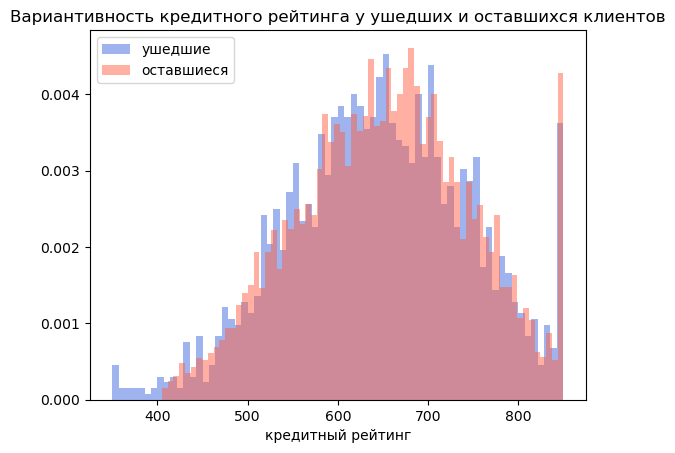

<Figure size 600x900 with 0 Axes>

In [23]:
plt.hist(data_ex['credit_score'], alpha = 0.5, bins = 70, color = 'royalblue', density=True, label='ушедшие')
plt.hist(data_not_ex['credit_score'], alpha = 0.5, bins = 70, color = 'tomato', density=True, label='оставшиеся')

plt.xlabel('кредитный рейтинг')
plt.legend()
plt.title('Вариантивность кредитного рейтинга у ушедших и оставшихся клиентов')
plt.figure(figsize=(6, 9))
plt.show()

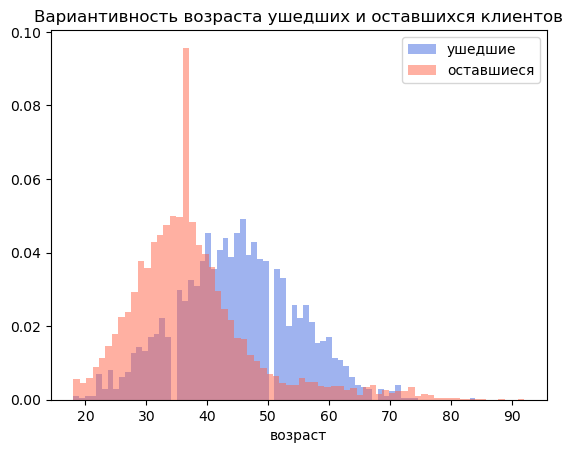

<Figure size 600x900 with 0 Axes>

In [26]:
plt.hist(data_ex['age'], alpha = 0.5, bins = 70, color = 'royalblue', density=True, label='ушедшие')
plt.hist(data_not_ex['age'], alpha = 0.5, bins = 70, color = 'tomato', density=True, label='оставшиеся')

plt.xlabel('возраст')
plt.legend()
plt.title('Вариантивность возраста ушедших и оставшихся клиентов')
plt.figure(figsize=(6, 9))
plt.show()

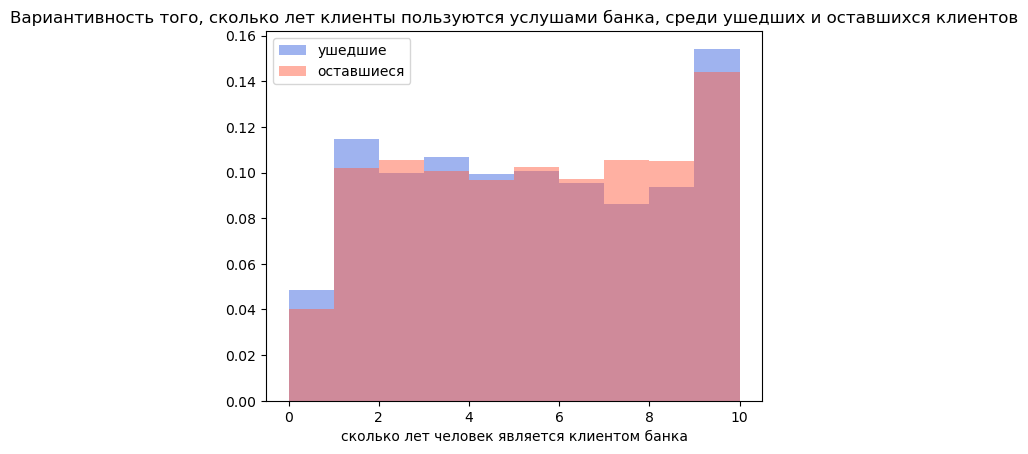

<Figure size 600x900 with 0 Axes>

In [27]:
plt.hist(data_ex['tenure'], alpha = 0.5, bins = 10, color = 'royalblue', density=True, label='ушедшие')
plt.hist(data_not_ex['tenure'], alpha = 0.5, bins = 10, color = 'tomato', density=True, label='оставшиеся')

plt.xlabel('сколько лет человек является клиентом банка')
plt.legend()
plt.title('Вариантивность того, сколько лет клиенты пользуются услушами банка, среди ушедших и оставшихся клиентов')
plt.figure(figsize=(6, 9))
plt.show()

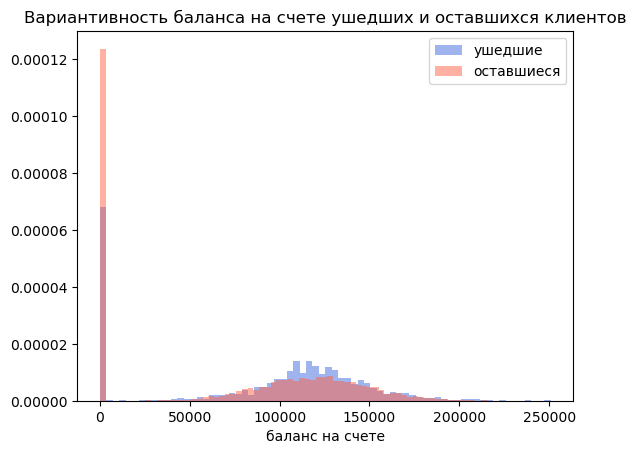

<Figure size 600x900 with 0 Axes>

In [28]:
plt.hist(data_ex['balance'], alpha = 0.5, bins = 70, color = 'royalblue', density=True, label='ушедшие')
plt.hist(data_not_ex['balance'], alpha = 0.5, bins = 70, color = 'tomato', density=True, label='оставшиеся')

plt.xlabel('баланс на счете')
plt.legend()
plt.title('Вариантивность баланса на счете ушедших и оставшихся клиентов')
plt.figure(figsize=(6, 9))
plt.show()

Стоит отдельно рассмотреть распределение баланса выше нуля у двух групп клиентов (ушедших и оставшихся)

In [29]:
data_1 = data_not_ex.loc[data_not_ex['balance'] > 0]
data_2 = data_ex.loc[data_ex['balance'] > 0]

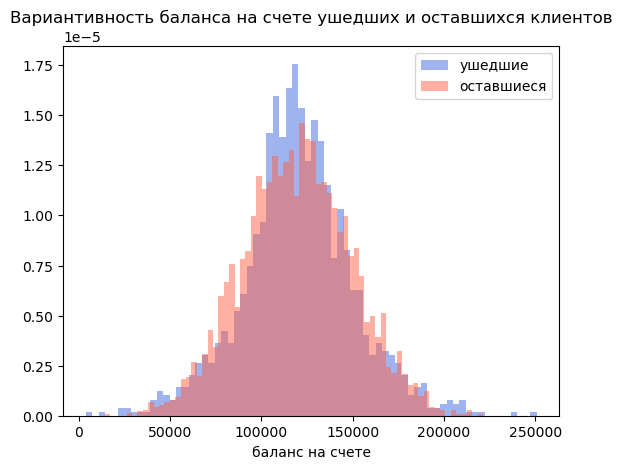

<Figure size 600x900 with 0 Axes>

In [30]:
plt.hist(data_2['balance'], alpha = 0.5, bins = 70, color = 'royalblue', density=True, label='ушедшие')
plt.hist(data_1['balance'], alpha = 0.5, bins = 70, color = 'tomato', density=True, label='оставшиеся')

plt.xlabel('баланс на счете')
plt.legend()
plt.title('Вариантивность баланса на счете ушедших и оставшихся клиентов')
plt.figure(figsize=(6, 9))
plt.show()

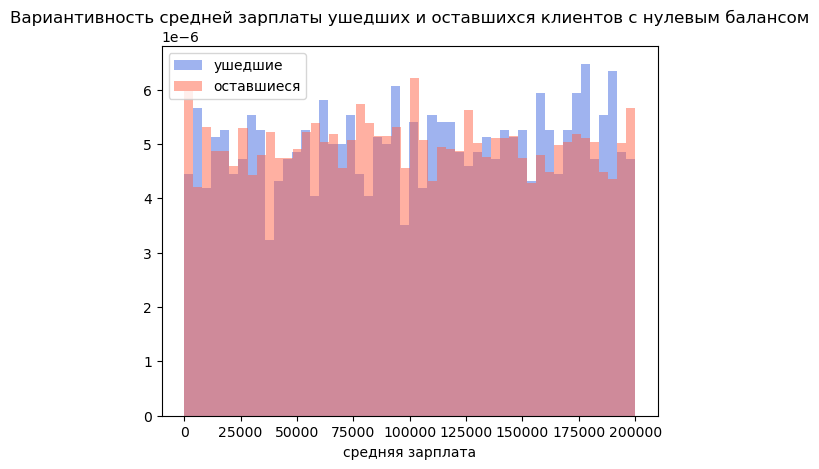

<Figure size 600x900 with 0 Axes>

In [31]:
plt.hist(data_ex['estimated_salary'], alpha = 0.5, bins = 50, color = 'royalblue', density=True, label='ушедшие')
plt.hist(data_not_ex['estimated_salary'], alpha = 0.5, bins = 50, color = 'tomato', density=True, label='оставшиеся')

plt.xlabel('средняя зарплата')
plt.legend()
plt.title('Вариантивность средней зарплаты ушедших и оставшихся клиентов с нулевым балансом')
plt.figure(figsize=(6, 9))
plt.show()

<Axes: xlabel='gender_male', ylabel='count'>

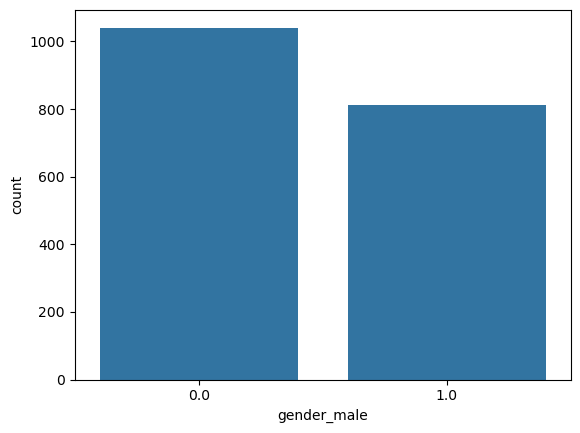

In [32]:
sns.countplot(x = 'gender_male',data = data_ex, legend = 'full')

<Axes: xlabel='gender_male', ylabel='count'>

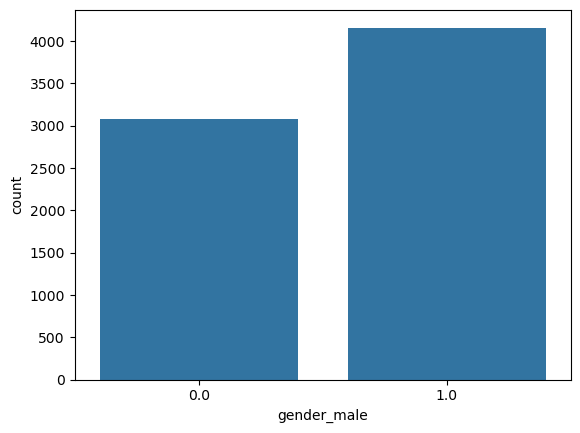

In [33]:
sns.countplot(x = 'gender_male',data = data_not_ex, legend = 'full')

In [115]:
data.groupby('geography')['geography'].count().sort_values()

geography
Spain      2248
Germany    2293
France     4550
Name: geography, dtype: int64

<Axes: xlabel='geography_spain', ylabel='count'>

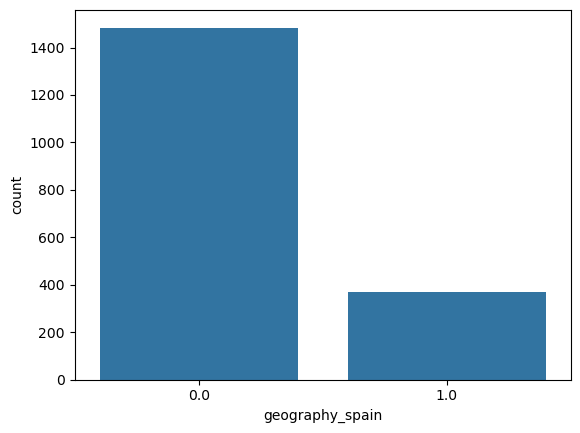

In [34]:
sns.countplot(x = 'geography_spain',data = data_ex, legend = 'full')

<Axes: xlabel='geography_spain', ylabel='count'>

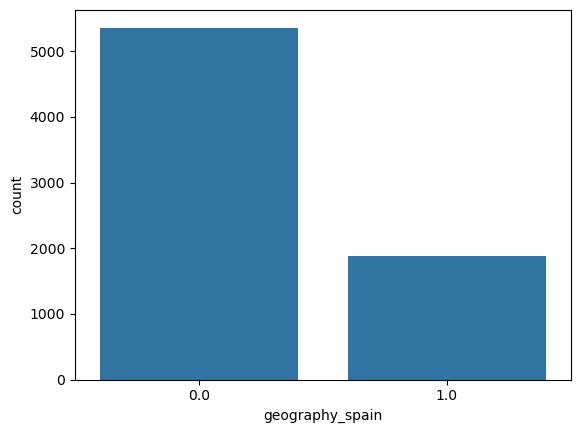

In [35]:
sns.countplot(x = 'geography_spain',data = data_not_ex, legend = 'full')

<Axes: xlabel='geography_germany', ylabel='count'>

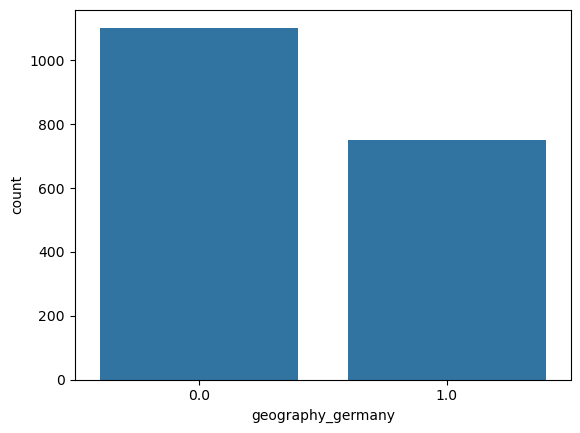

In [36]:
sns.countplot(x = 'geography_germany',data = data_ex, legend = 'full')

<Axes: xlabel='geography_germany', ylabel='count'>

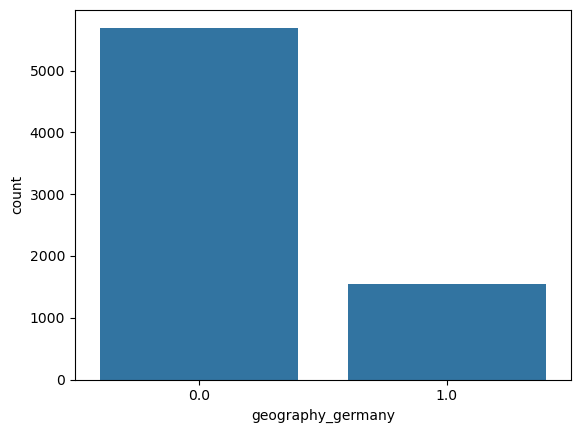

In [37]:
sns.countplot(x = 'geography_germany',data = data_not_ex, legend = 'full')

<Axes: xlabel='num_of_products', ylabel='count'>

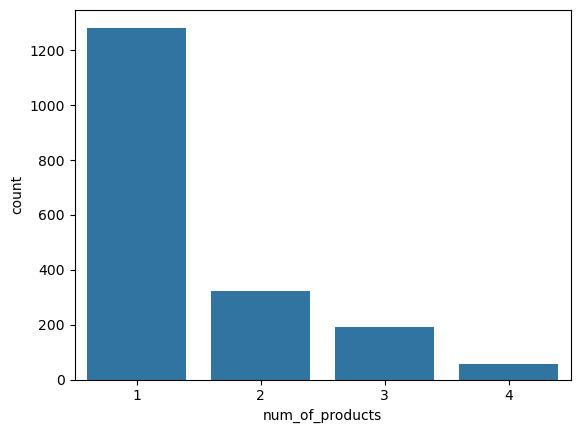

In [38]:
sns.countplot(x = 'num_of_products',data = data_ex, legend = 'full')

<Axes: xlabel='num_of_products', ylabel='count'>

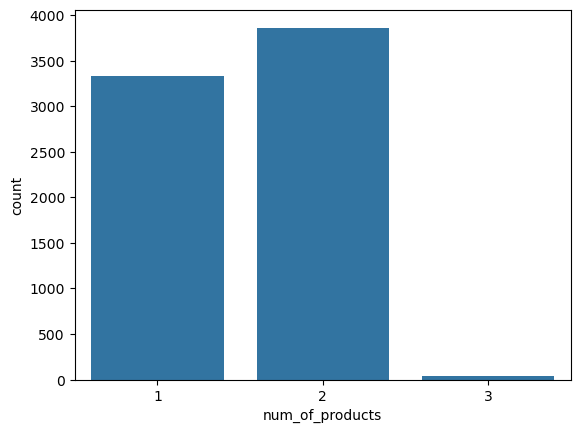

In [39]:
sns.countplot(x = 'num_of_products',data = data_not_ex, legend = 'full')

<Axes: xlabel='has_cr_card', ylabel='count'>

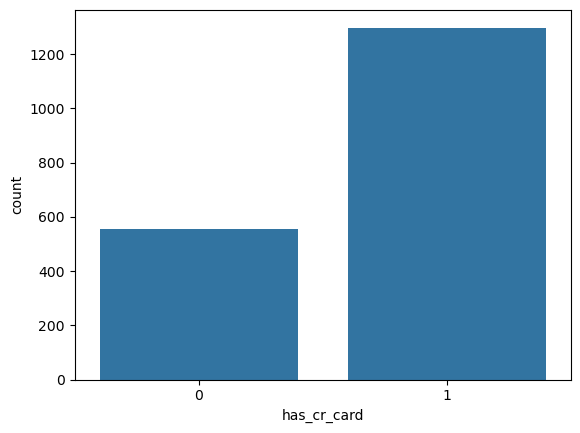

In [40]:
sns.countplot(x = 'has_cr_card',data = data_ex, legend = 'full')

<Axes: xlabel='has_cr_card', ylabel='count'>

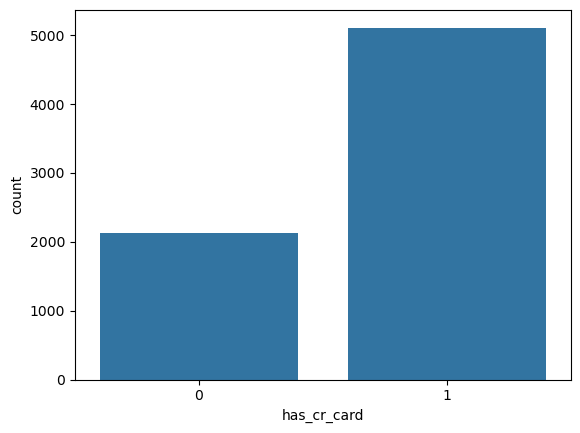

In [41]:
sns.countplot(x = 'has_cr_card',data = data_not_ex, legend = 'full')

<Axes: xlabel='is_active_member', ylabel='count'>

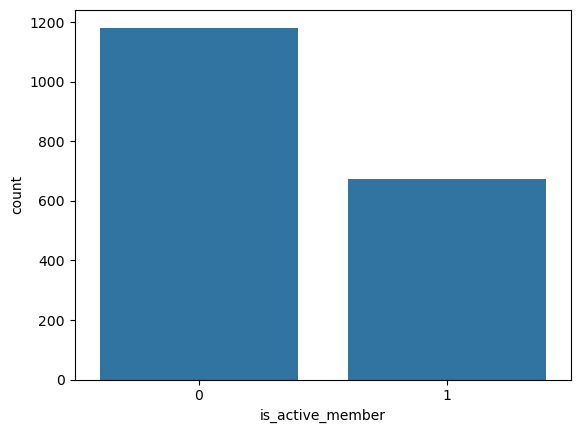

In [42]:
sns.countplot(x = 'is_active_member',data = data_ex, legend = 'full')

<Axes: xlabel='is_active_member', ylabel='count'>

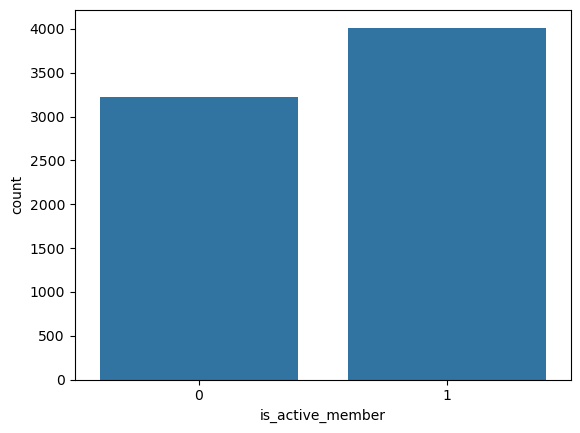

In [43]:
sns.countplot(x = 'is_active_member',data = data_not_ex, legend = 'full')

### **Клиенты с нулевым балансом**

В ходе анализа была обнаружена категория клиентов, информация о которой потенциально может быть полезна для заказчика - клиенты с нулевым балансом. Стоит отдельно рассмотреть её

In [44]:
data_0_not = data_not_ex.loc[data_not_ex['balance'] == 0]
data_0_not.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
3,699,39,1.0,0.0,2,0,0,93826.63,0,0.0,0.0,0.0
6,822,50,7.0,0.0,2,1,1,10062.80,0,0.0,0.0,1.0
11,497,24,3.0,0.0,2,1,0,76390.01,0,0.0,1.0,1.0
12,476,34,10.0,0.0,2,1,0,26260.98,0,0.0,0.0,0.0
13,549,25,5.0,0.0,2,0,0,190857.79,0,0.0,0.0,0.0


In [45]:
data_0_ex = data_ex.loc[data_ex['balance'] == 0]
data_0_ex.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.0,1,1,1,101348.88,1,0.0,0.0,0.0
22,510,38,4.0,0.0,1,1,0,118913.53,1,0.0,1.0,0.0
58,511,66,4.0,0.0,1,1,0,1643.11,1,0.0,1.0,0.0
81,777,32,2.0,0.0,1,1,0,136458.19,1,0.0,0.0,0.0
88,646,46,4.0,0.0,3,1,0,93251.42,1,0.0,0.0,0.0


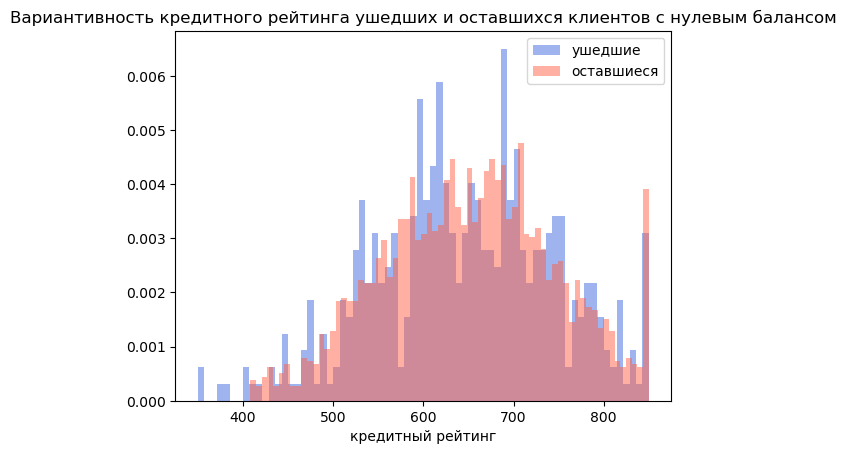

<Figure size 600x900 with 0 Axes>

In [46]:
plt.hist(data_0_ex['credit_score'], alpha = 0.5, bins = 70, color = 'royalblue', density=True, label='ушедшие')
plt.hist(data_0_not['credit_score'], alpha = 0.5, bins = 70, color = 'tomato', density=True, label='оставшиеся')

plt.xlabel('кредитный рейтинг')
plt.legend()
plt.title('Вариантивность кредитного рейтинга ушедших и оставшихся клиентов с нулевым балансом')
plt.figure(figsize=(6, 9))
plt.show()

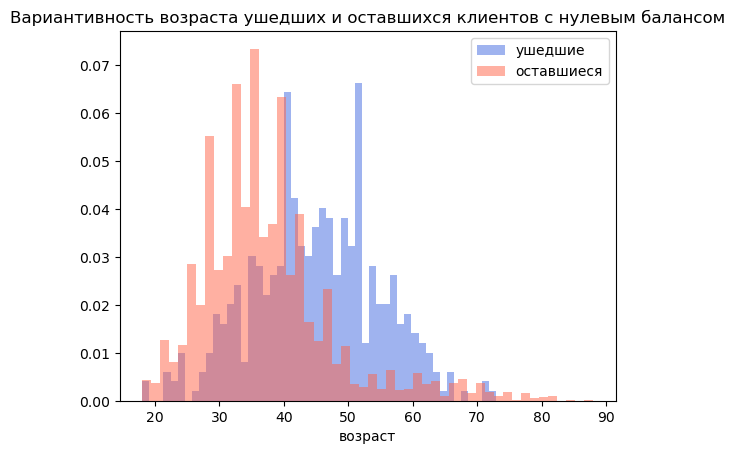

<Figure size 600x900 with 0 Axes>

In [47]:
plt.hist(data_0_ex['age'], alpha = 0.5, bins = 50, color = 'royalblue', density=True, label='ушедшие')
plt.hist(data_0_not['age'], alpha = 0.5, bins = 50, color = 'tomato', density=True, label='оставшиеся')

plt.xlabel('возраст')
plt.legend()
plt.title('Вариантивность возраста ушедших и оставшихся клиентов с нулевым балансом')
plt.figure(figsize=(6, 9))
plt.show()

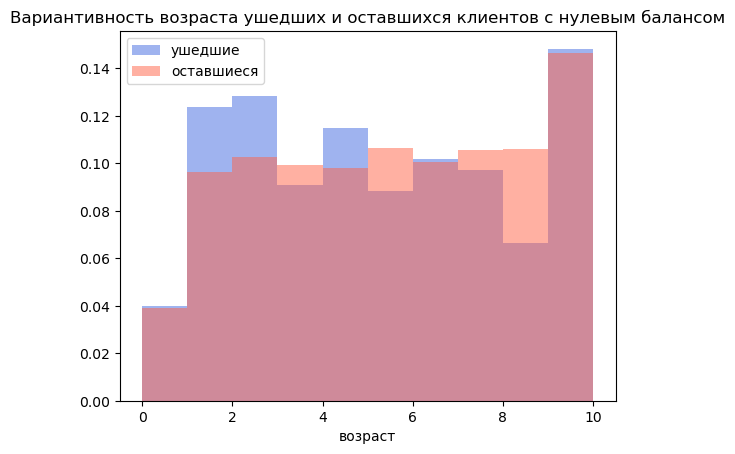

<Figure size 600x900 with 0 Axes>

In [48]:
plt.hist(data_0_ex['tenure'], alpha = 0.5, bins = 10, color = 'royalblue', density=True, label='ушедшие')
plt.hist(data_0_not['tenure'], alpha = 0.5, bins = 10, color = 'tomato', density=True, label='оставшиеся')

plt.xlabel('возраст')
plt.legend()
plt.title('Вариантивность возраста ушедших и оставшихся клиентов с нулевым балансом')
plt.figure(figsize=(6, 9))
plt.show()

In [49]:
data_0_ex.loc[data_0_ex['tenure']==0]['tenure'].count()

18

In [50]:
data_0_ex.loc[data_0_ex['is_active_member']==0]['is_active_member'].count()

292

In [51]:
data_0_ex.loc[data_0_ex['is_active_member']==1]['is_active_member'].count()

160

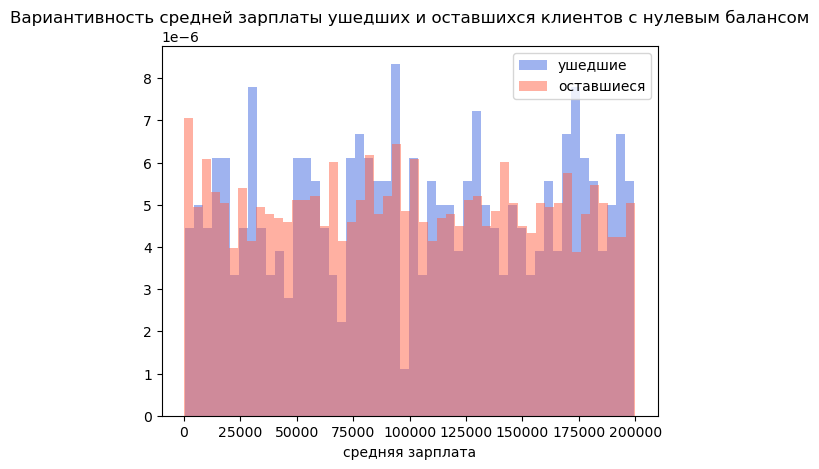

<Figure size 600x900 with 0 Axes>

In [52]:
plt.hist(data_0_ex['estimated_salary'], alpha = 0.5, bins = 50, color = 'royalblue', density=True, label='ушедшие')
plt.hist(data_0_not['estimated_salary'], alpha = 0.5, bins = 50, color = 'tomato', density=True, label='оставшиеся')

plt.xlabel('средняя зарплата')
plt.legend()
plt.title('Вариантивность средней зарплаты ушедших и оставшихся клиентов с нулевым балансом')
plt.figure(figsize=(6, 9))
plt.show()

In [53]:
data_0_ex.loc[data_0_ex['estimated_salary']<10000]['estimated_salary'].count()

19

In [54]:
data_0_not.loc[data_0_not['estimated_salary']<10000]['estimated_salary'].count()

170

<Axes: xlabel='gender_male', ylabel='count'>

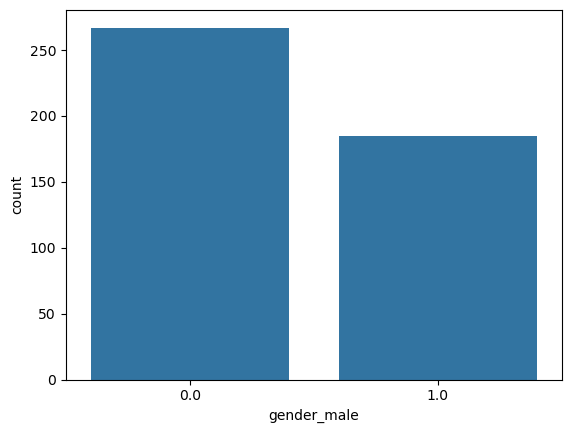

In [55]:
sns.countplot(x = 'gender_male',data = data_0_ex, legend = 'full')

<Axes: xlabel='gender_male', ylabel='count'>

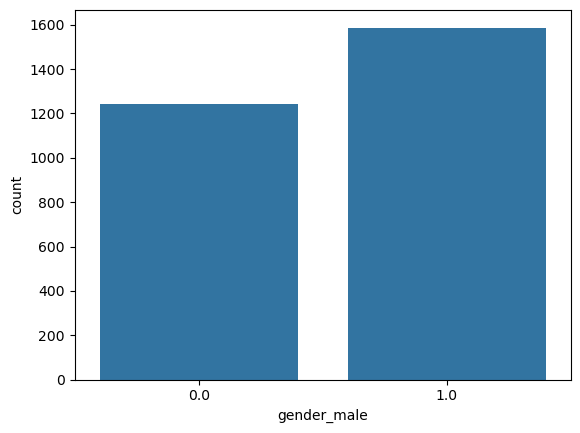

In [56]:
sns.countplot(x = 'gender_male',data = data_0_not, legend = 'full')

<Axes: xlabel='geography_spain', ylabel='count'>

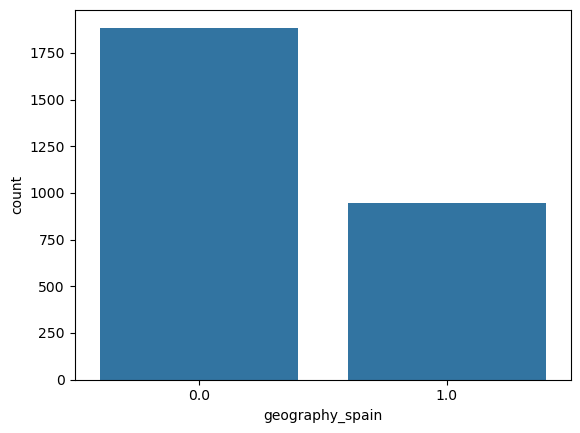

In [57]:
sns.countplot(x = 'geography_spain',data = data_0_not, legend = 'full')

<Axes: xlabel='geography_spain', ylabel='count'>

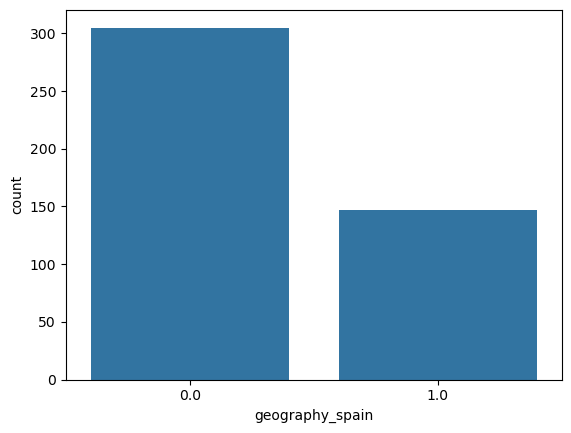

In [58]:
sns.countplot(x = 'geography_spain',data = data_0_ex, legend = 'full')

<Axes: xlabel='geography_germany', ylabel='count'>

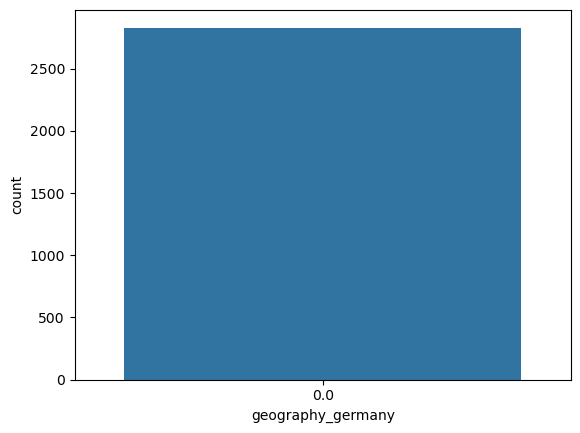

In [59]:
sns.countplot(x = 'geography_germany',data = data_0_not, legend = 'full')

<Axes: xlabel='geography_germany', ylabel='count'>

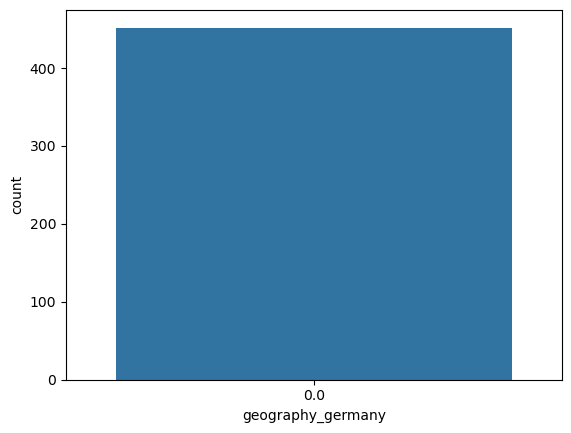

In [60]:
sns.countplot(x = 'geography_germany',data = data_0_ex, legend = 'full')

<Axes: xlabel='num_of_products', ylabel='count'>

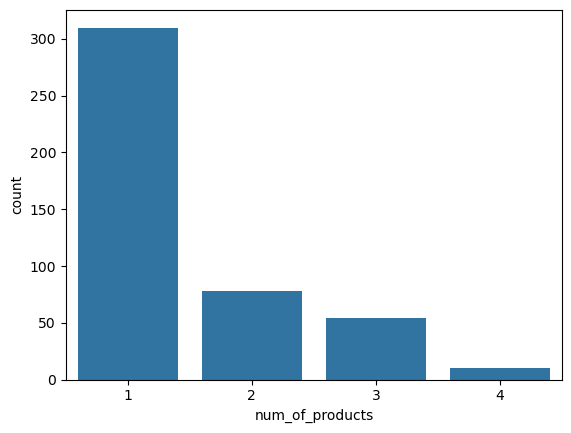

In [61]:
sns.countplot(x = 'num_of_products',data = data_0_ex, legend = 'full')

<Axes: xlabel='num_of_products', ylabel='count'>

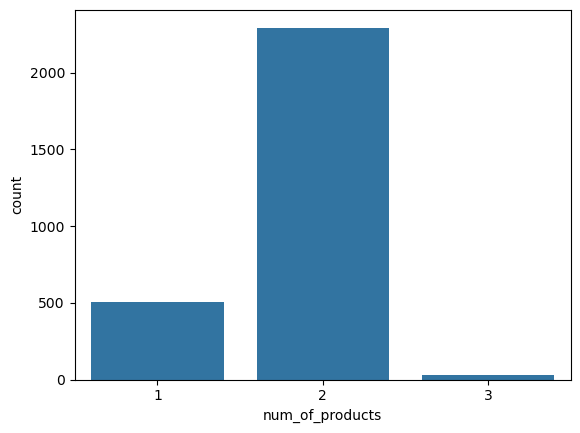

In [62]:
sns.countplot(x = 'num_of_products',data = data_0_not, legend = 'full')

<Axes: xlabel='has_cr_card', ylabel='count'>

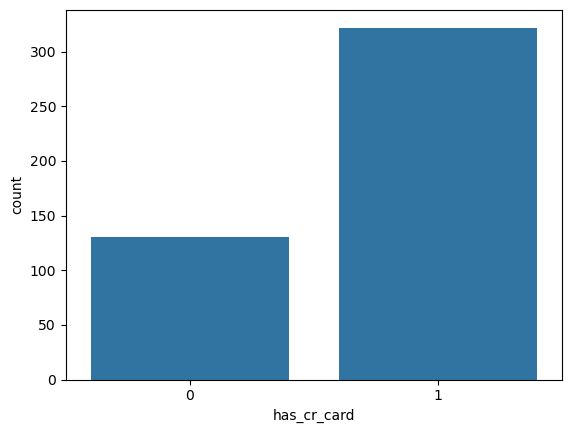

In [63]:
sns.countplot(x = 'has_cr_card',data = data_0_ex, legend = 'full')

<Axes: xlabel='has_cr_card', ylabel='count'>

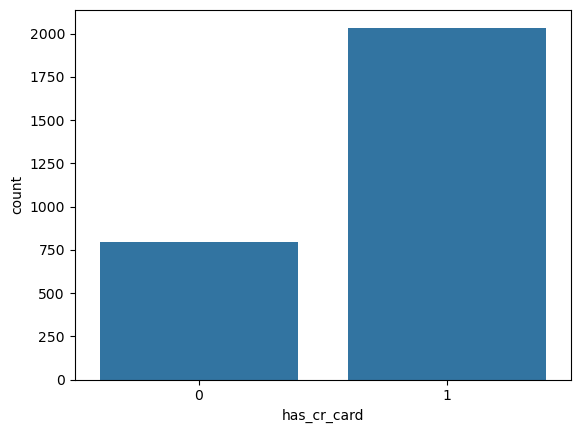

In [64]:
sns.countplot(x = 'has_cr_card',data = data_0_not, legend = 'full')

<Axes: xlabel='is_active_member', ylabel='count'>

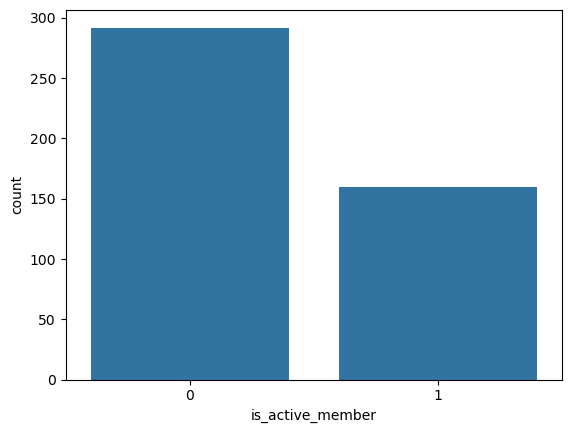

In [65]:
sns.countplot(x = 'is_active_member',data = data_0_ex, legend = 'full')

<Axes: xlabel='is_active_member', ylabel='count'>

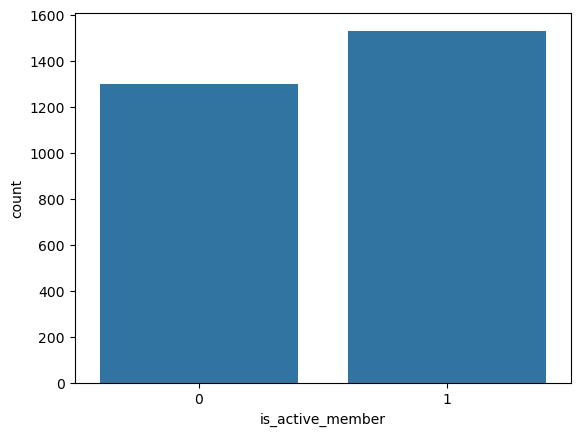

In [66]:
sns.countplot(x = 'is_active_member',data = data_0_not, legend = 'full')

Проанализировав разными способами категорию клиентов банка, у которых баланс  равен 0, можно сделать несколько заключений и предположений:   
- Неактивных клиентов больше, чем активных как среди тех, кто ушел , однако, и среди тех, кто остался их ненамного меньше активных
- И у архивных (неактивных) клиентов, и у активных была кредитная карта
- Нет клиентов из Германии
- Оставшиеся клиенты в основном пользовались 2мя продуктами банка, в то время как ушедшие 1м
- Среди ушедших больше клиентов-женщин, чем клиентов-мужчин, в то время как среди оставшихся клиентов ситуация обратная
- Кредитный рейтинг и средняя заработная плата не отличаются между ушедшими и неушедшими группами
- Возрастной диапазон ушедших клиентов смещен в большую сторону у группы ушедших клиентов на 10-15 лет - у оставшихся от 20-50, а у ушедших 30-65

### **Вывод по разделу исследовательского анализа**

На основании визуализации полученных от заказчика данных, были сделаны несколько выводов относительно различий и сходств двух групп клиентов банка - тех, кто ушли и тех, кто остались:   
- Распределения кредитного рейтинга, средней зарплаты, баланса и срока пользования услугами банка не отличаются
- Возрастной диапазон у ушедших клиентов несколько смещен к более высоким значениям - от 25 до 65 со средним значением возраста 44, а у оставшихся - от 18 до 50 со средним значением возраста 37
- Клиенты из обоих групп чаще всего имели кредитные карты
- Среди клиентов банка больше клиентов из Франции (4550) и меньше всего из Испании (2248) и немного больше из Германии (2293)
- В предоставленных заказчиком данных довольно много записей о неактивных клиентах из обоих групп, однако среди ушедших их больше
- Среди оставшихся клиентов больше мужчин, чем женщин и обратная ситуация с группой ушедших клиентов
- Ушедшие клиенты чаще пользовались 1м продуктом, а оставшиеся - 2мя

Данные особенности клиентского поведения можно гипотетически объяснить выгодностью цен на пакеты услуг, а также спецификой воздействия рекламной компании на разные категории клиентов, а также адаптированности для лиц различного возраста.

# Подготовка признаков к обучению модели

На данном этапе необходимо рассмотреть количественные признаки на предмет мультиколлениарности и размера корреляции с целевым признаком (факт ухода клиента)

<Axes: >

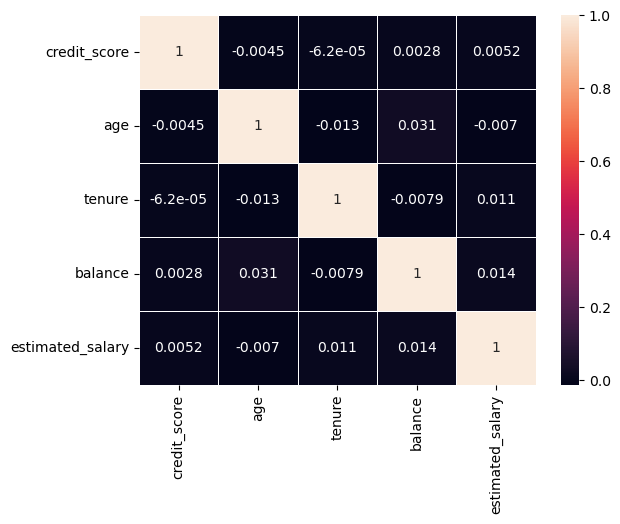

In [67]:
sns.heatmap(data_copy.drop(['exited', 'num_of_products', 'is_active_member', 'has_cr_card', 'geography_germany', 'geography_spain', 'gender_male'], axis=1).corr(), linewidths=.7, annot=True)

Таким образом, мультикорреляция среди количественных признаков не была выявлена.
Далее я проверю ее наличие среди категориальных признаков с помощью коэффициента Крамера.

In [68]:
data_cat = data_copy[['exited', 'num_of_products', 'is_active_member', 'has_cr_card', 'geography_germany', 'geography_spain', 'gender_male']]

In [69]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape)-1 
    return (stat/(obs*mini))

In [70]:
rows= []

for var1 in data_cat:
    col = []
    for var2 in data_cat:
        cramers =cramers_V(data_cat[var1], data_cat[var2])
        col.append(round(cramers,2)) 
    rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns =data_cat.columns, index =data_cat.columns)

df

,exited,num_of_products,is_active_member,has_cr_card,geography_germany,geography_spain,gender_male
exited,1.00,0.15,0.02,0.0,0.03,0.00,0.01
num_of_products,0.15,1.00,0.00,0.0,0.00,0.00,0.00
is_active_member,0.02,0.00,1.00,0.0,0.00,0.00,0.00
has_cr_card,0.00,0.00,0.00,1.0,0.00,0.00,0.00
geography_germany,0.03,0.00,0.00,0.0,1.00,0.11,0.00
geography_spain,0.00,0.00,0.00,0.0,0.11,1.00,0.00
gender_male,0.01,0.00,0.00,0.0,0.00,0.00,1.00


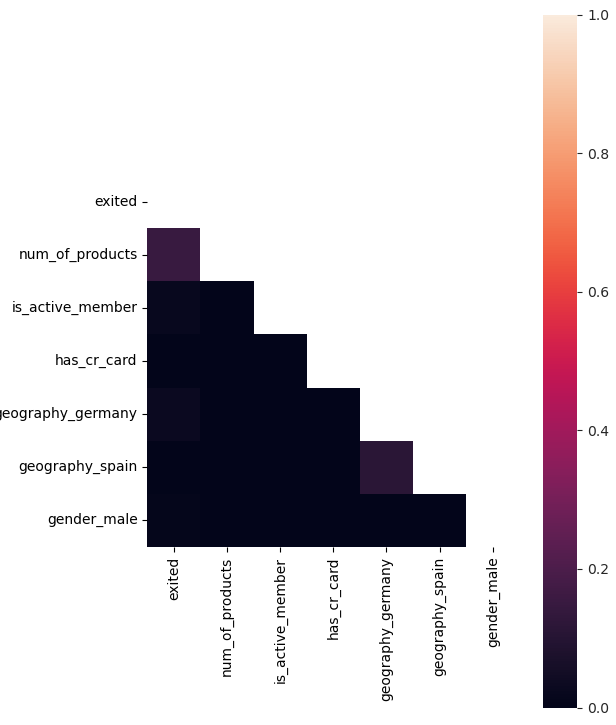

In [71]:
mask = np.zeros_like(df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(6, 9))
with sns.axes_style("white"):
    ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

Таким образом, все признаки не избыточны и не создадут проблемы интерпретируемости модели а также ее неточности. 

Прежде чем перейти к финальному шагу подготовки признаков к обучению, следует проверить их корреляцию непосредственно с целевым признаком

In [72]:
def cor(col1):
    return col1.corr(data_copy['exited'])

In [73]:
for a in data_copy.columns:
    if cor(data_copy[a]) > 0.5:
        print(a)

exited


Корреляции с целевым признаком не обнаружено, а значит, можно переходить к масштабированию количественных признаков.

In [74]:
data_train, data_val = train_test_split(data_copy, test_size=0.4, random_state=SEED)

In [75]:
data_val, data_test = train_test_split(data_val, test_size=0.5, random_state=SEED)

In [76]:
features_train = data_train.drop(columns = ['exited'])
target_train = data_train['exited']

features_val = data_val.drop(columns = ['exited'])
target_val = data_val['exited']

features_test = data_test.drop(columns = ['exited'])
target_test = data_test['exited']

В датасете присутствуют несколько столбцов с количественными переменными - credit_score, age, tenure, balance, estimated_salary. Оценим разброс диапазона значений.

In [77]:
razn_credit_score = data_train['credit_score'].max() - data_train['credit_score'].min()
razn_credit_score

500

In [78]:
razn_age = data_train['age'].max() - data_train['age'].min()
razn_age

74

In [79]:
razn_tenure = data_train['tenure'].max() - data_train['tenure'].min()
razn_tenure

10.0

In [80]:
razn_balance = data_train['balance'].max() - data_train['balance'].min()
razn_balance

238387.56

In [81]:
razn_estimated_salary = data_train['estimated_salary'].max() - data_train['estimated_salary'].min()
razn_estimated_salary

199941.75

Чтобы какой-то признак не воспринимался моделью как более значимый из-за более широкого диапазона и в принципе более высоких значений, следует их масштабировать методом стандартизации данных.  

In [82]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

In [83]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_val[numeric] = scaler.transform(features_val[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_val.shape)
print(features_test.shape)

(5454, 11)
(1818, 11)
(1819, 11)


In [84]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
9344,0.809075,-1.039327,-1.025995,0.554904,1,1,0,0.019508,0.0,0.0,0.0
3796,-1.152518,-1.227561,0.696524,0.480609,1,0,0,0.056167,0.0,0.0,1.0
7462,-0.398853,0.090079,1.385532,-1.237830,1,1,1,0.848738,0.0,0.0,1.0
1508,-0.749875,-0.286389,0.352020,-1.237830,2,1,1,-0.894953,0.0,0.0,1.0
4478,-1.028628,-0.756975,-0.336987,-1.237830,2,0,1,-1.284516,0.0,0.0,1.0


# Исследование задачи

Теперь следует проверить, в каком состоянии находятся значения разных классов.

exited
0    0.793546
1    0.206454
Name: proportion, dtype: float64


<Axes: xlabel='exited'>

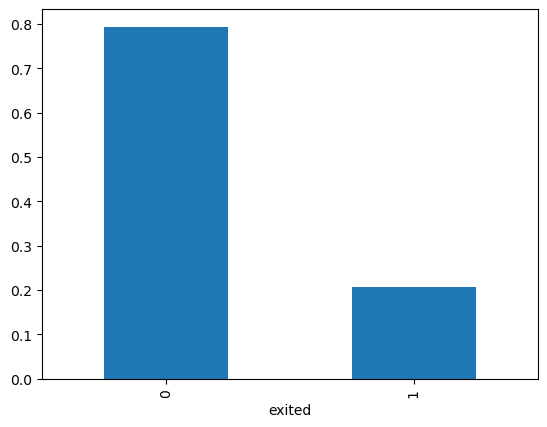

In [85]:
class_frequency = target_train.value_counts(normalize= True)
print(class_frequency)
class_frequency.plot(kind='bar')

exited
0    0.792629
1    0.207371
Name: proportion, dtype: float64


<Axes: xlabel='exited'>

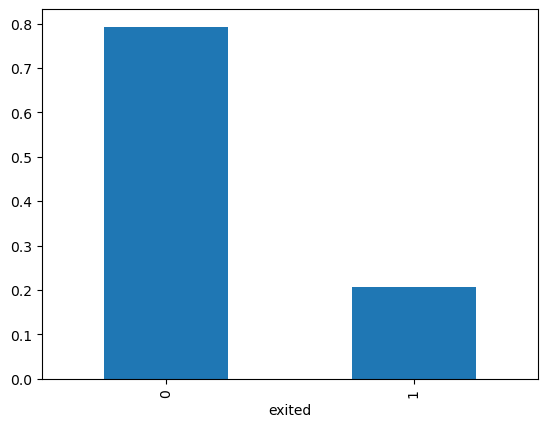

In [86]:
class_frequency = target_val.value_counts(normalize= True)
print(class_frequency)
class_frequency.plot(kind='bar')

exited
0    0.807037
1    0.192963
Name: proportion, dtype: float64


<Axes: xlabel='exited'>

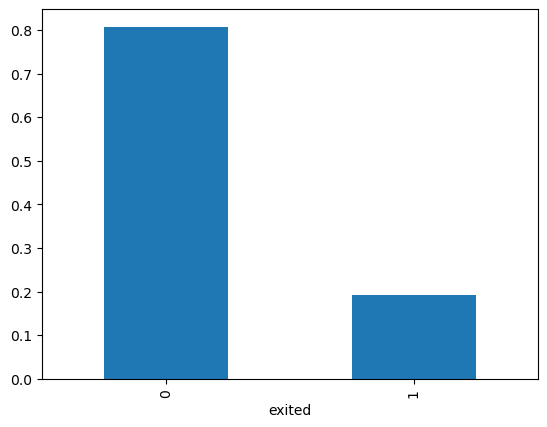

In [87]:
class_frequency = target_test.value_counts(normalize= True)
print(class_frequency)
class_frequency.plot(kind='bar')

**Вывод:** Наблюдается явный дисбаланс классов во всех выборках.

Далее я хочу найти лучшие гиперпараметры для моделей решающего дерева, случайного леса и логистическую регрессию. Лучшая модель для обучения на данных о клиентском поведении будет выбрана на основе лучших показателей AUC-ROC и F1.

In [88]:
criterion_type = ['gini', 'entropy']
splitter_type = ['best', 'random']


best_model = None
best_depth = 0
best_recall = 0
best_crit = 0
best_splitter = 0
best_split = 0
best_leaf = 0
best_f1 = 0

for crit in criterion_type:
    for splt in splitter_type:
        for split in range(2, 100):
            for leaf in (1, 100):
                for depth in range(1, 20):
                    model_des = DecisionTreeClassifier(random_state=12345, max_depth = depth, criterion = crit, splitter = splt, min_samples_split = split, min_samples_leaf = leaf)

                    model_des.fit(features_train, target_train)
                    predict_valid = model_des.predict(features_val)
                    predict_train = model_des.predict(features_train)
                    
                    f1_val = f1_score(target_val, predict_valid)
                    #f1_train = f1_score(target_val, predict_train)
                    
                    if (f1_val > 0.58) and (f1_val > best_f1):
                        best_model = model_des
                        best_depth = depth
                        best_leaf = leaf
                        best_split = split
                        best_splitter = splt
                        best_crit = crit
                        
                    if f1_val > best_f1:
                        best_f1 = f1_val
                        

print(f'Лучшая метрика F1: {best_f1}')

print(f'max_depth: {best_depth}')
print(f'criterion: {best_crit}')
print(f'splitter: {best_splitter}')
print(f'min_samples_split: {best_split}')
print(f'min_samples_leaf: {best_leaf}')
import warnings

warnings.filterwarnings("ignore")


Лучшая метрика F1: 0.6189024390243902
max_depth: 10
criterion: gini
splitter: random
min_samples_split: 49
min_samples_leaf: 1


In [89]:
model_1 = DecisionTreeClassifier(random_state = 12345,criterion = 'gini', max_depth = 10, splitter = 'random', min_samples_leaf = 1, min_samples_split = 49)

In [90]:
model_1.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=49, random_state=12345,
                       splitter='random')

In [91]:
predict_valid = model_1.predict(features_val)

In [93]:
probabilities_valid = model_1.predict_proba(features_val)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_val, probabilities_one_valid)
auc_roc

0.854700445645431

In [94]:
criterion_type = ['gini', 'entropy']

best_model = None
best_depth = 0
best_est = 0
best_crit = 0
best_f1 = 0

for crit in criterion_type:
    for est in range(10, 100, 10):
        for depth in range(1, 10):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth= depth, criterion = crit)

            model.fit(features_train, target_train)
            predict_valid = model.predict(features_val)

            f1_val = f1_score(target_val, predict_valid)
            #f1_train = f1_score(target_val, predict_train)

            if (f1_val > 0.55) and (f1_val > best_f1):
                best_model = model
                best_depth = depth
                best_est = est
                best_crit = crit
            if f1_val > best_f1:
                best_f1 = f1_val
                        

print(f'Лучшая метрика F1: {best_f1}')
print(f'')
print(f'n_estimators: {best_est}')
print(f'max_depth: {best_depth}')
print(f'criterion: {best_crit}')
import warnings

warnings.filterwarnings("ignore")

Лучшая метрика F1: 0.5758620689655173

n_estimators: 20
max_depth: 8
criterion: gini


In [95]:
model_2 = RandomForestClassifier(random_state = 12345, max_depth= 8, n_estimators=20, criterion='gini')
model_2.fit(features_train, target_train)
predict_valid = model_2.predict(features_val)

In [97]:
probabilities_valid = model_2.predict_proba(features_val)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_val, probabilities_one_valid)
auc_roc

0.8664297008598141

In [98]:
solver_type = ['saga', 'liblinear']
penalty_type = ['l1', 'l2']

best_model = None
best_penalty = 0
best_max_iter = 0
best_solver = 0
best_f1 = 0

for sol in solver_type:
    for pen in penalty_type:
        for iteration in range(100, 1000, 10):
            model = LogisticRegression(random_state=12345, solver = sol, penalty = pen, max_iter = iteration)

            model.fit(features_train, target_train)
            predict_valid = model.predict(features_val)
            f1_val = f1_score(target_val, predict_valid)

            if (f1_val > 0.2) and (f1_val > best_f1):
                best_model = model
                best_solver = sol
                best_penalty = pen
                best_max_iter = iteration
                    
            if f1_val > best_f1:
                best_f1 = f1_val
                        

print(f'Лучшая метрика F1: {best_f1}')
print(f'')
print(f'penalty {best_penalty}, solver {best_solver} и количестве итераций {best_max_iter}')

import warnings

warnings.filterwarnings("ignore")

Лучшая метрика F1: 0.304

penalty l2, solver saga и количестве итераций 100


In [99]:
model_3 =LogisticRegression(random_state = 12345,  solver = 'saga', penalty = 'l2', max_iter = 100)
model_3.fit(features_train, target_train)
predict_valid = model_3.predict(features_val)

In [101]:
probabilities_valid = model_3.predict_proba(features_val)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_val, probabilities_one_valid)
auc_roc

0.7736614530507661

**Вывод:** Из данного анализа видно, что метрика точности предсказаний модели (среднее гармоническое точности и полноты) выше у модели дерева решений - 0.62. Также у данной модели приемлемая и площадь под кривой ошибок (показатель auc_roc) - 0.85, хотя самый высокий показатель у модели случайного леса - 0,87. У модели логистической регрессии показатели ниже

## Борьба с дисбалансом

Для борьбы с дисбалансом я планирую применить несколько стратегий: upsample и downsample. Затем следует подобрать нужные гиперпараметры для модели дерева решений для того, чтобы корректно протестировать модель.

In [102]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [103]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Далее следует подобрать подходящие гиперпараметры и выбрать оптимальную стратегию. 

In [104]:
best_roc_auc = 0
criterion_type = ['gini', 'entropy']
splitter_type = ['best', 'random']
best_model = None
best_depth = 0
best_crit = 0
best_splitter = 0
best_split = 0
best_leaf = 0
best_f1 = 0
best_rep = 0

for crit in criterion_type:
    for splt in splitter_type:
        for split in range(2, 50, 2):
            for leaf in (1, 50):
                for depth in range(1, 20):
                    for a in range(3, 6):
                        features_upsampled, target_upsampled = upsample(features_train, target_train, a)

                        model_des = DecisionTreeClassifier(random_state=12345, max_depth = depth, criterion = crit, splitter = splt, min_samples_split = split, min_samples_leaf = leaf)

                        model_des.fit(features_upsampled, target_upsampled)
                        predict_valid = model_des.predict(features_val)

                        f1_val = f1_score(target_val, predict_valid)
                        #f1_train = f1_score(target_val, predict_train)
                        probabilities_valid = model_des.predict_proba(features_val)
                        probabilities_one_valid = probabilities_valid[:, 1]
                        roc_auc = roc_auc_score(target_val, probabilities_one_valid)

                        if (f1_val > 0.58) and (f1_val > best_f1):
                            best_model = model_des
                            best_depth = depth
                            best_leaf = leaf
                            best_split = split
                            best_splitter = splt
                            best_crit = crit
                            best_rep = a

                        if f1_val > best_f1:
                            best_f1 = f1_val
                        
                        if roc_auc > best_roc_auc:
                            best_roc_auc = roc_auc

print(f'Лучшая метрика F1: {best_f1}')
print("auc_roc:", best_roc_auc)
print('repest:', best_rep)
print(f'max_depth: {best_depth}')
print(f'criterion: {best_crit}')
print(f'splitter: {best_splitter}')
print(f'min_samples_split: {best_split}')
print(f'min_samples_leaf: {best_leaf}')
import warnings

warnings.filterwarnings("ignore")

Лучшая метрика F1: 0.6285714285714286
auc_roc: 0.8535720662596156
repest: 3
max_depth: 10
criterion: entropy
splitter: random
min_samples_split: 40
min_samples_leaf: 1


**Вывод:** При стратегии upsample лучшим параметром repeat стало 3, при следующих гиперпараметрах:  
'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 40, criterion: entropy, splitter: random при которых F1: 0.6285714285714286 и auc_roc: 0.8535720662596156

In [105]:
best_roc_auc = 0
criterion_type = ['gini', 'entropy']
splitter_type = ['best', 'random']
best_model = None
best_depth = 0
best_crit = 0
best_splitter = 0
best_split = 0
best_leaf = 0
best_f1 = 0
best_rep = 0

for crit in criterion_type:
    for splt in splitter_type:
        for split in range(2, 50, 2):
            for leaf in (1, 50):
                for depth in range(1, 20):
                    for a in np.arange(0.1, 0.4):
                        features_downsampled, target_downsampled = downsample(features_train, target_train, a)

                        model_des = DecisionTreeClassifier(random_state=12345, max_depth = depth, criterion = crit, splitter = splt, min_samples_split = split, min_samples_leaf = leaf)

                        model_des.fit(features_downsampled, target_downsampled)
                        predict_valid = model_des.predict(features_val)

                        f1_val = f1_score(target_val, predict_valid)
                        #f1_train = f1_score(target_val, predict_train)
                        probabilities_valid = model_des.predict_proba(features_val)
                        probabilities_one_valid = probabilities_valid[:, 1]
                        roc_auc = roc_auc_score(target_val, probabilities_one_valid)

                        if (f1_val > 0.5) and (f1_val > best_f1):
                            best_model = model_des
                            best_depth = depth
                            best_leaf = leaf
                            best_split = split
                            best_splitter = splt
                            best_crit = crit
                            best_rep = a

                        if f1_val > best_f1:
                            best_f1 = f1_val
                        
                        if roc_auc > best_roc_auc:
                            best_roc_auc = roc_auc

print(f'Лучшая метрика F1: {best_f1}')
print("auc_roc:", best_roc_auc)
print('fraction:', best_rep)
print(f'max_depth: {best_depth}')
print(f'criterion: {best_crit}')
print(f'splitter: {best_splitter}')
print(f'min_samples_split: {best_split}')
print(f'min_samples_leaf: {best_leaf}')
import warnings

warnings.filterwarnings("ignore")

Лучшая метрика F1: 0.5205905205905206
auc_roc: 0.838494487875904
fraction: 0.1
max_depth: 5
criterion: gini
splitter: best
min_samples_split: 16
min_samples_leaf: 1


**Вывод:** При стратегии downsampled лучшим параметром fraction стало 0.1, при следующих гиперпараметрах:  
'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 16, при которых F1: 0.5205905205905206 и auc_roc: 0.838494487875904

Теперь следует подобрать гиперпараметры для модели случайного леса.

In [106]:
criterion_type = ['gini', 'entropy']
best_roc_auc = 0
best_model = None
best_depth = 0
best_est = 0
best_crit = 0
best_f1 = 0
best_rep = 0

for crit in criterion_type:
    for est in range(10, 100, 10):
        for depth in range(1, 10):
            for a in range(3, 6):
                features_upsampled, target_upsampled = upsample(features_train, target_train, a)
                model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth= depth, criterion = crit)

                model.fit(features_downsampled, target_downsampled)
                predict_valid = model.predict(features_val)

                f1_val = f1_score(target_val, predict_valid)
                #f1_train = f1_score(target_val, predict_train)

                if (f1_val > 0.4) and (f1_val > best_f1):
                    best_model = model
                    best_depth = depth
                    best_est = est
                    best_crit = crit
                    best_rep = a
                if f1_val > best_f1:
                    best_f1 = f1_val
                if roc_auc > best_roc_auc:
                    best_roc_auc = roc_auc


print(f'Лучшая метрика F1: {best_f1}')
print("auc_roc:", best_roc_auc)
print('repest:', best_rep)
print(f'')
print(f'n_estimators: {best_est}')
print(f'max_depth: {best_depth}')
print(f'criterion: {best_crit}')
import warnings

warnings.filterwarnings("ignore")

Лучшая метрика F1: 0.46942800788954636
auc_roc: 0.8075321624939946
repest: 3

n_estimators: 20
max_depth: 8
criterion: entropy


**Вывод:** При стратегии upsample лучшим параметром repeat стало 3, при следующих гиперпараметрах:  
'max_depth': 8, 'n_estimators': 20, criterion: entropy при которых F1: 0.46942800788954636 и auc_roc: 0.8075321624939946

In [107]:
criterion_type = ['gini', 'entropy']
best_roc_auc = 0
best_model = None
best_depth = 0
best_est = 0
best_crit = 0
best_f1 = 0
best_rep = 0

for crit in criterion_type:
    for est in range(10, 100, 10):
        for depth in range(1, 10):
            for a in np.arange(0.1, 0.4):
                features_downsampled, target_downsampled = downsample(features_train, target_train, a)
                model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth= depth, criterion = crit)

                model.fit(features_downsampled, target_downsampled)
                predict_valid = model.predict(features_val)

                f1_val = f1_score(target_val, predict_valid)
                #f1_train = f1_score(target_val, predict_train)

                if (f1_val > 0.4) and (f1_val > best_f1):
                    best_model = model
                    best_depth = depth
                    best_est = est
                    best_crit = crit
                    best_rep = a
                if f1_val > best_f1:
                    best_f1 = f1_val
                if roc_auc > best_roc_auc:
                    best_roc_auc = roc_auc


print(f'Лучшая метрика F1: {best_f1}')
print("auc_roc:", best_roc_auc)
print('fraction:', best_rep)
print(f'')
print(f'n_estimators: {best_est}')
print(f'max_depth: {best_depth}')
print(f'criterion: {best_crit}')
import warnings

warnings.filterwarnings("ignore")

Лучшая метрика F1: 0.46942800788954636
auc_roc: 0.8075321624939946
fraction: 0.1

n_estimators: 20
max_depth: 8
criterion: entropy


**Вывод:** При стратегии downsample лучшим параметром fraction стало 0.1, при следующих гиперпараметрах:  
'max_depth': 8, 'n_estimators': 20, criterion: entropy при которых F1:0.46942800788954636 и auc_roc: 0.8075321624939946

Теперь следует проверить, какая стратегия борьбы с дисбалансом классов эффективнее у модели логистической регрессии

In [108]:
solver_type = ['saga', 'liblinear']
penalty_type = ['l1', 'l2']
best_roc_auc = 0
best_model = None
best_penalty = 0
best_max_iter = 0
best_solver = 0
best_f1 = 0
best_rep = 0

for sol in solver_type:
    for pen in penalty_type:
        for iteration in range(100, 1000, 10):
            for a in range(3, 6):
                features_upsampled, target_upsampled = upsample(features_train, target_train, a)
                model = LogisticRegression(random_state=12345, solver = sol, penalty = pen, max_iter = iteration)

                model.fit(features_upsampled, target_upsampled)
                predict_valid = model.predict(features_val)
                f1_val = f1_score(target_val, predict_valid)

                if (f1_val > 0.2) and (f1_val > best_f1):
                    best_model = model
                    best_solver = sol
                    best_penalty = pen
                    best_max_iter = iteration
                    best_rep = a
                if f1_val > best_f1:
                    best_f1 = f1_val
                if roc_auc > best_roc_auc:
                    best_roc_auc = roc_auc
                        

print(f'Лучшая метрика F1: {best_f1}')
print("auc_roc:", best_roc_auc)
print('repest:', best_rep)
print(f'')
print(f'penalty {best_penalty}, solver {best_solver} и количестве итераций {best_max_iter}')

import warnings

warnings.filterwarnings("ignore")

Лучшая метрика F1: 0.5095194922937444
auc_roc: 0.8075321624939946
repest: 4

penalty l1, solver liblinear и количестве итераций 100


**Вывод:** При стратегии upsample лучшим параметром repeat стало 4, при следующих гиперпараметрах:  
penalty: l1, solver: liblinear и количестве итераций 100

In [109]:
solver_type = ['saga', 'liblinear']
penalty_type = ['l1', 'l2']
best_roc_auc = 0
best_model = None
best_penalty = 0
best_max_iter = 0
best_solver = 0
best_f1 = 0
best_rep = 0

for sol in solver_type:
    for pen in penalty_type:
        for iteration in range(100, 1000, 10):
            for a in np.arange(0.1, 0.4):
                features_downsampled, target_downsampled = downsample(features_train, target_train, a)
                model = LogisticRegression(random_state=12345, solver = sol, penalty = pen, max_iter = iteration)

                model.fit(features_downsampled, target_downsampled)
                predict_valid = model.predict(features_val)
                f1_val = f1_score(target_val, predict_valid)

                if (f1_val > 0.2) and (f1_val > best_f1):
                    best_model = model
                    best_solver = sol
                    best_penalty = pen
                    best_max_iter = iteration
                    best_rep = a
                if f1_val > best_f1:
                    best_f1 = f1_val
                if roc_auc > best_roc_auc:
                    best_roc_auc = roc_auc
                        

print(f'Лучшая метрика F1: {best_f1}')
print("auc_roc:", best_roc_auc)
print('fraction:', best_rep)
print(f'')
print(f'penalty {best_penalty}, solver {best_solver} и количестве итераций {best_max_iter}')

import warnings

warnings.filterwarnings("ignore")

Лучшая метрика F1: 0.4153846153846154
auc_roc: 0.8075321624939946
fraction: 0.1

penalty l2, solver saga и количестве итераций 100


**Вывод:** При стратегии downsample лучшим параметром fraction стало 0.1, при следующих гиперпараметрах:  
penalty l2, solver saga и количестве итераций 100 при которых F1: 0.41538461538461535 и auc_roc: 0.8075321624939946

**Общий вывод:** В результате подбора оптимальных гиперпараметров у 3х моделей (дерева решений, случайного леса и логистической регрессии) по двум стратегиям борьбы с дисбалансом классов лучше других по метрике точности F1 и auc_roc показала себя модель дерева решений в стратегии повышения выборки - F1: 0.6285714285714286 и auc_roc: 0.8535720662596156. Такая комбинация будет использоваться для проверки на тестовой выборке.

Следовательно, для проверки модели на тестовой выборке будет использоваться стратегия балансировки классов upsampled

Далее следует построить PR кривую для того, чтобы визуализировать соотношение полноты и точности модели.

Оптимальное значение thresholds: 0.50
Оптимальное значение f1 на валидационной выборке: 0.63


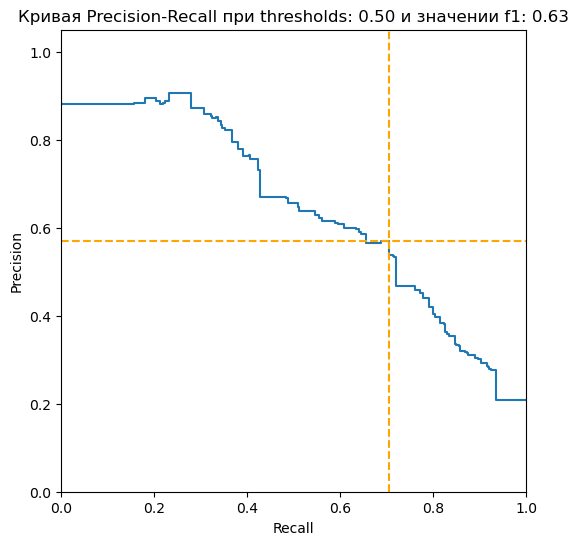

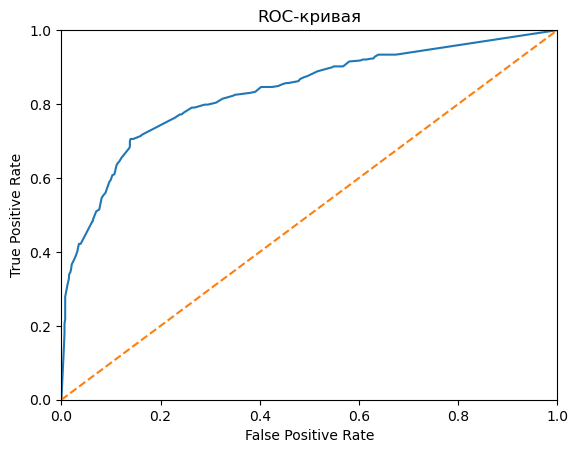

In [110]:
model = DecisionTreeClassifier(random_state=12345, max_depth= 10, min_samples_leaf =1, min_samples_split = 40, criterion = 'entropy', splitter = 'random')
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
model.fit(features_upsampled, target_upsampled)

probabilities_val = model.predict_proba(features_val)
precision, recall, thresholds = precision_recall_curve(target_val, probabilities_val[:, 1])
fscores = np.divide((2 * precision * recall)
                        , (precision + recall)
                        , where=(precision + recall)!=0)


optimal_idx = np.argmax(fscores)

print(f'Оптимальное значение thresholds: {thresholds[optimal_idx]:.2f}')
print(f'Оптимальное значение f1 на валидационной выборке: {np.max(fscores):.2f}')

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.vlines(recall[optimal_idx], ymin=0, ymax=1.05, linestyles='--', color='orange')
plt.hlines(precision[optimal_idx], xmin=0, xmax=1, linestyles='--', color='orange')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Кривая Precision-Recall при thresholds: {thresholds[optimal_idx]:.2f} и значении f1: {np.max(fscores):.2f}')
plt.show()

probabilities_one_valid = probabilities_val[:, 1]
fpr, tpr, thresholds = roc_curve(target_val, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

# Тестирование модели

In [111]:
model = DecisionTreeClassifier(random_state=12345, max_depth= 10, min_samples_leaf =1, min_samples_split = 40, criterion = 'entropy', splitter = 'random')
features_upsampled, target_upsampled = upsample(features_test, target_test, 3)
model.fit(features_upsampled, target_upsampled)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=40,
                       random_state=12345, splitter='random')

In [112]:
probabilities_test = model.predict(features_test) > 0.5
predicted_score = f1_score(target_test, probabilities_test)

In [113]:
print('F1:', predicted_score)

F1: 0.6574307304785895


In [114]:
probabilities_test = model.predict_proba(features_test) > 0.5
probabilities_one_test = probabilities_test[:, 1]
print("auc_roc:", roc_auc_score(target_test, probabilities_one_test))

auc_roc: 0.8098057709774331


**Общий вывод по проекту**  
- В ходе проекта были рассмотрены несколько моделей обучения - дерево решений, случайного леса и логистической регрессии.  
- Были предварительно обработаны категориальные признаки методом горячего кодирования, что повысило точность предсказаний модели. 
- На выбранных моделях были протестированы стратегии борьбы с дисбалансом классов - лучшей стратегией стало увеличение выборки редкого класса. 
- Модель дерева решений показала лучшую точность F1 и auc-roc до борьбы с дисбалансом и после неё (F1: 0.6189024390243902 и 0.6285714285714286, соответственно).  
- На тестовой выборке точность F1 этой модели составила 0.6574307304785895, а auc_roc 0.8098057709774331.  
- Следовательно, заказчику для исходных данных можно передать модель дерева решений с гиперпараметрами (random_state=12345, max_depth= 10, min_samples_leaf =1, min_samples_split = 40, criterion = 'entropy', splitter = 'random') для наиболее точных прелсказаний оттока клиентов на основании пользовательского поведения.